In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, random
from scipy.stats import norm
from scipy.optimize import minimize
import time

In [ ]:
SP500_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='SP500 Tech')
ftse_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='Vanguard FTSE')
gold_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='Gold ETF')
alphabet_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='Alphabet')
IAG_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='IAG')

In [ ]:
IAG_data

,Unnamed: 0,LON:IAG - Close
0,2018-06-22,7.266
1,2018-06-25,6.978
2,2018-06-26,6.732
3,2018-06-27,6.694
4,2018-06-28,6.604
...,...,...
1842,2025-07-15,3.772
1843,2025-07-16,3.805
1844,2025-07-17,3.840
1845,2025-07-18,3.804


In [ ]:
def construct_df(df):
    df = df.set_index('Unnamed: 0')
    df.columns.values[0] = 'Close'
    df['Returns'] = df['Close'].pct_change()
    df['Volatility'] = df['Returns'].rolling(window=252).std() * np.sqrt(252)
    df['CumProd'] = 100*(1+df['Returns']).cumprod()
    return df

def getDrawdowns(cumprod):
    peak = cumprod.cummax()
    drawdowns = (cumprod - peak) / peak
    return drawdowns

def getHistoricalVAR(df, level = 5):
    return np.percentile(df['Returns'].dropna(), level)

def getParametricVAR(df, level =5):
    mu = df['Returns'].mean()
    sigma = df['Returns'].std()
    z = norm.ppf(level / 100)
    return mu + z * sigma

def getCVaR(df, level = 5, VAR='Historical'):
    if VAR == 'Historical':
        var = getHistoricalVAR(df, level)
    if VAR == 'Parametric':
        var = getParametricVAR(df, level)
    else:
        pass
    return df['Returns'][df['Returns'] <= var].mean()
SP500 = construct_df(sp500_data)
FTSE = construct_df(ftse_data)
Alphabet = construct_df(alphabet_data)
Gold = construct_df(gold_data)
IAG = construct_df(IAG_data)

combined_df = pd.DataFrame({
    'SP500Tech': SP500['Returns'],
    'FTSE': FTSE['Returns'],
    'Alphabet': Alphabet['Returns'],
    'Gold': Gold['Returns'],
    'IAG': IAG['Returns']
})
covMatrix = combined_df.cov()

def portfolio_return(weights, returns):
    return np.dot(weights, returns.mean()) * 252

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))

def sharpe_ratio(weights, returns, risk_free_rate=0.0354):
    port_return = portfolio_return(weights, returns)
    port_vol = portfolio_volatility(weights, returns.cov())
    return (port_return - risk_free_rate) / port_vol

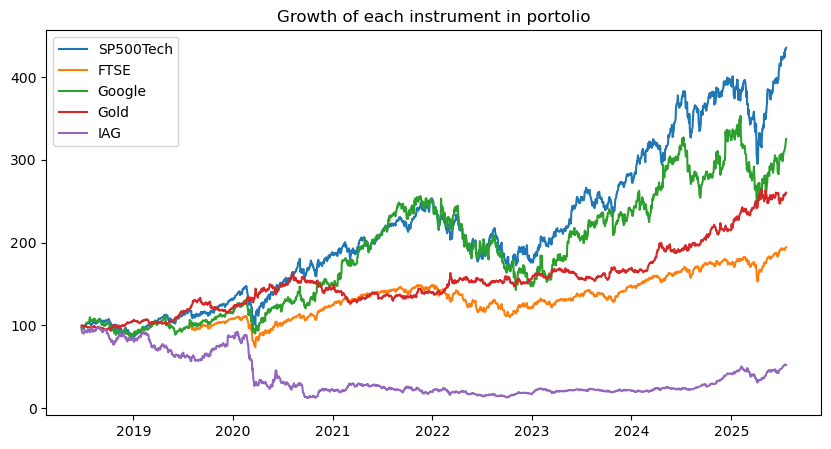

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(SP500.index, SP500['CumProd'], label = 'SP500Tech')
plt.plot(FTSE.index, FTSE['CumProd'], label = 'FTSE')
plt.plot(Alphabet.index, Alphabet['CumProd'], label = 'Google')
plt.plot(Gold.index, Gold['CumProd'], label = 'Gold')
plt.plot(IAG.index, IAG['CumProd'], label = 'IAG')
plt.legend()
plt.title('Growth of each instrument in portolio')
plt.show()

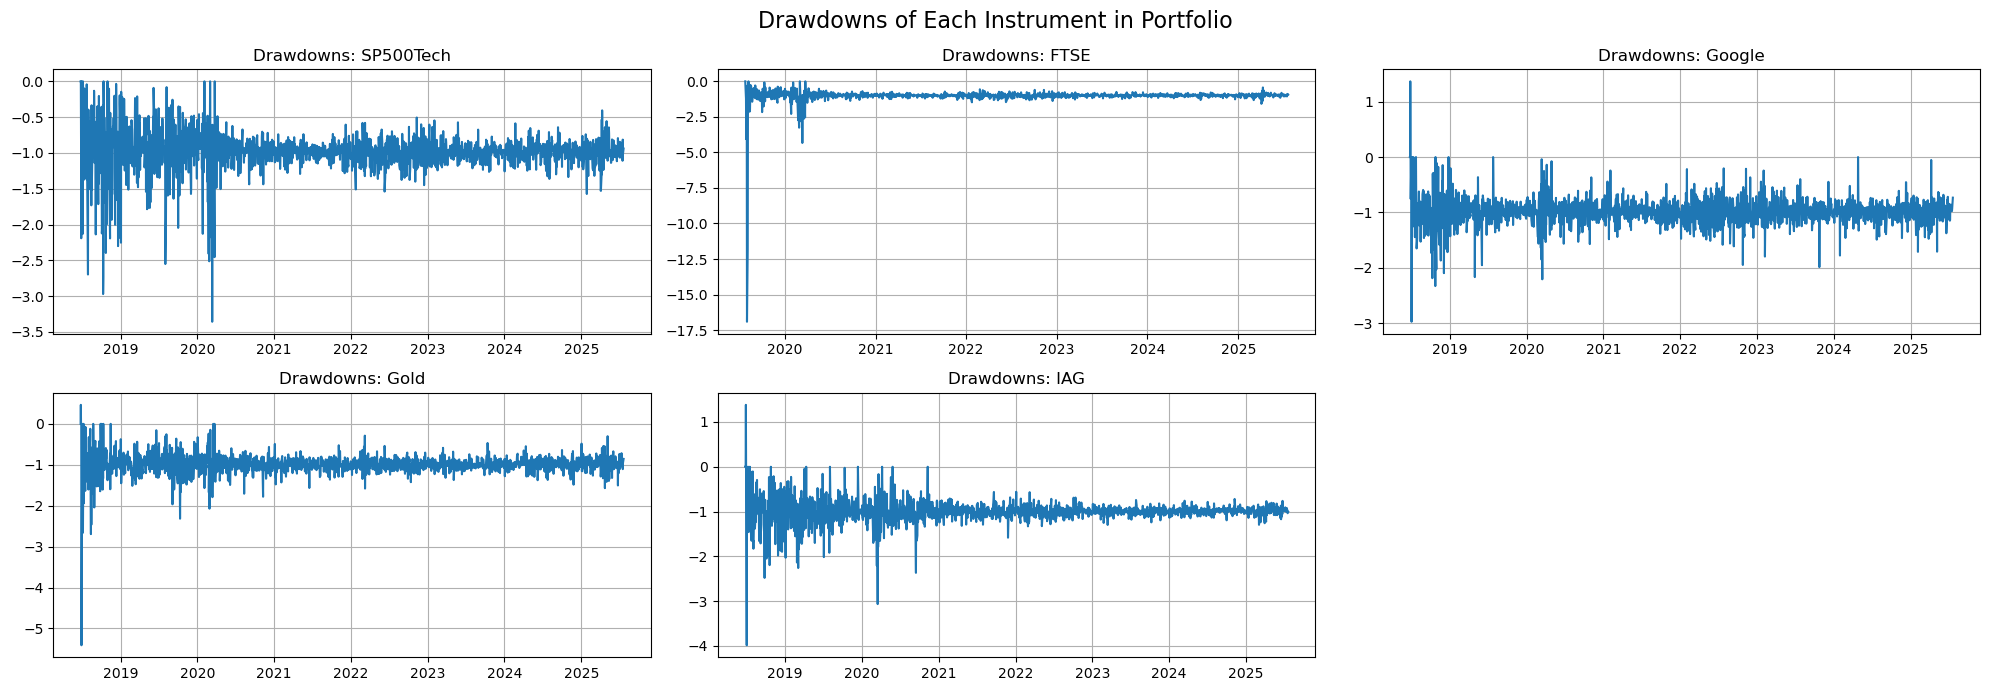

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 7))
axes = ax.flatten()

instruments = [('SP500Tech', SP500), ('FTSE', FTSE), ('Google', Alphabet), ('Gold', Gold), ('IAG', IAG)]
for i, (name, df) in enumerate(instruments):
    axes[i].plot(df.index, getDrawdowns(df['Returns']), label=name)
    axes[i].set_title(f'Drawdowns: {name}')
    axes[i].grid(True)
fig.delaxes(axes[-1])

fig.suptitle('Drawdowns of Each Instrument in Portfolio', fontsize=16)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


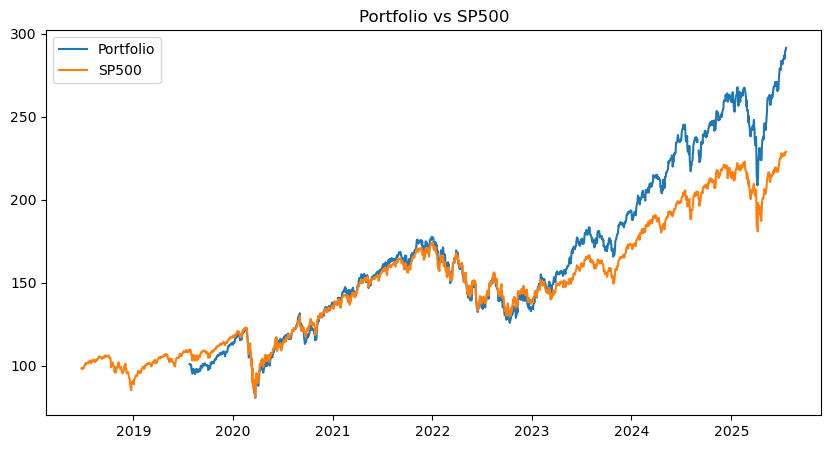

In [ ]:
weights = {
    'SP500Tech':0.5044,
    'FTSE': 0.3009,
    'Alphabet' : 0.0956,
    'Gold' : 0.0313,
    'IAG' : 0.0678
} #as they stand today
weights_array = np.array([weights[col] for col in combined_df.columns])
portfolio_rets = combined_df.dot(weights_array)
portfolio_cumprod = 100*(1 + portfolio_rets).cumprod()
portfolio_drawdowns = getDrawdowns(portfolio_cumprod)

import yfinance as yf
benchmark = yf.download('^GSPC', start = '2018-06-22')['Close']
benchmark_returns = benchmark.pct_change()
benchmark_cumprod = 100* (1 + benchmark_returns).cumprod()

plt.figure(figsize=(10,5))
plt.plot(portfolio_cumprod, label='Portfolio')
plt.plot(benchmark.index, benchmark_cumprod, label='SP500')
plt.title('Portfolio vs SP500')
plt.legend()
plt.show()

In [ ]:
start = pd.Timestamp('2025-02-28')
print(start in benchmark_cumprod.index)

True


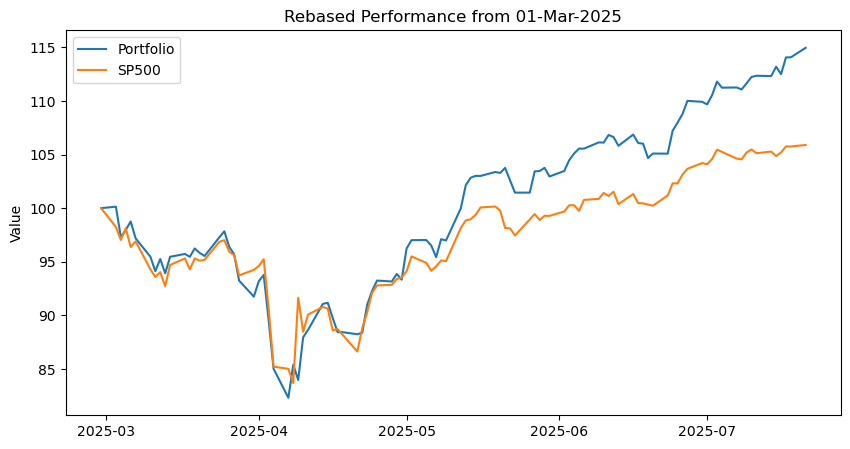

Sharpe Ratio: 0.96
Annual Volatility: 20.24%
Max Drawdown: -34.33%
CAGR: 116.91%


In [ ]:
#rebase at 01-March-2025 (as when I started)
start ='2025-02-28'
pos = benchmark_cumprod.index.get_indexer([start], method='nearest')[0]

portfolio_cumprod_rebased = portfolio_cumprod[start:] / portfolio_cumprod[start] * 100
benchmark_cumprod_rebased = benchmark_cumprod.iloc[pos:] / benchmark_cumprod.iloc[pos] * 100

plt.figure(figsize=(10, 5))
plt.plot(portfolio_cumprod_rebased, label='Portfolio')
plt.plot(benchmark_cumprod_rebased, label='SP500')
plt.title('Rebased Performance from 01-Mar-2025')
plt.ylabel('Value')
plt.legend()
plt.show()

sharpe_ratio = portfolio_rets.mean() / portfolio_rets.std() * np.sqrt(252)
volatility = portfolio_rets.std() * np.sqrt(252)
max_drawdown = portfolio_drawdowns.min()
cagr = (portfolio_cumprod.iloc[-1])**(252 / len(portfolio_cumprod)) - 1

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Annual Volatility: {volatility:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"CAGR: {cagr:.2%}")

# The portfolio current weighting beats the market. Lets see if I can imporve this

Optimal Weights (Max Sharpe):
SP500Tech: 0.3068
FTSE: 0.0017
Alphabet: 0.1088
Gold: 0.5707
IAG: 0.0120

Sharpe Ratio: 1.4973
Annualized Volatility: 0.1207
Total Return: 11349.48%


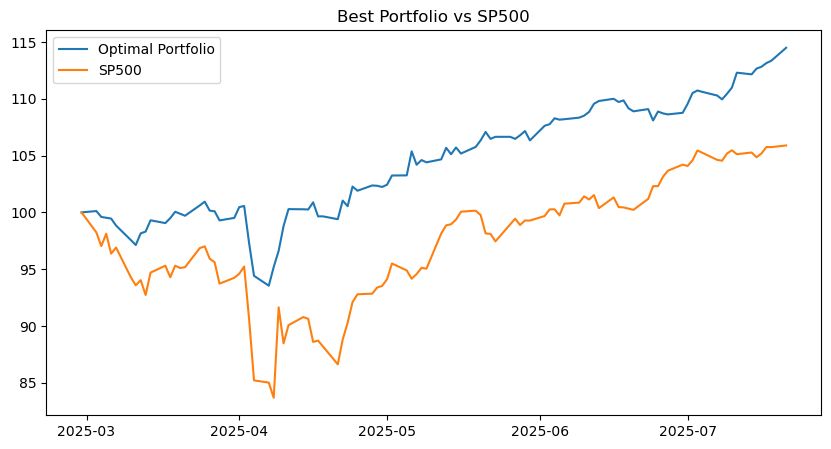

In [ ]:
def sim_portfolio_weights(n=1000):
    res = []
    weights = np.random.dirichlet(np.ones(5), size=n)
    for x in weights:
        port_rets = combined_df.dot(x)
        port_cumprod = 100* (1 + port_rets).cumprod()
        port_cumprod_rebased = port_cumprod[start:] / port_cumprod[start] * 100
        res.append({
            'weights': x,
            'cumprod': port_cumprod_rebased,
            'return': port_cumprod_rebased.iloc[-1] - 1,
            'volatility': port_rets.std() * np.sqrt(252),
            'sharpe': (port_rets.mean() / port_rets.std()) * np.sqrt(252)
        })
    return res
time_start = time.time()
sims = sim_portfolio_weights(50000)
best = max(sims, key=lambda x: x['sharpe'])

print("Optimal Weights (Max Sharpe):")
for name, weight in zip(combined_df.columns, best['weights']):
    print(f"{name}: {weight:.4f}")

print(f"\nSharpe Ratio: {best['sharpe']:.4f}")
print(f"Annualized Volatility: {best['volatility']:.4f}")
print(f"Total Return: {best['return']:.2%}")

plt.figure(figsize=(10, 5))
plt.plot(best['cumprod'], label='Optimal Portfolio')
plt.plot(benchmark_cumprod_rebased, label='SP500')
plt.title('Best Risk Adjusted Portfolio vs SP500')
plt.legend()
plt.show()

time_end = time.time()
print(time_end-time_start, 's')

Optimal Weights (Max Return):
SP500Tech: 0.9302
FTSE: 0.0299
Alphabet: 0.0254
Gold: 0.0081
IAG: 0.0063

Sharpe Ratio: 0.9908
Annualized Volatility: 0.2376
Total Return: 11726.09%


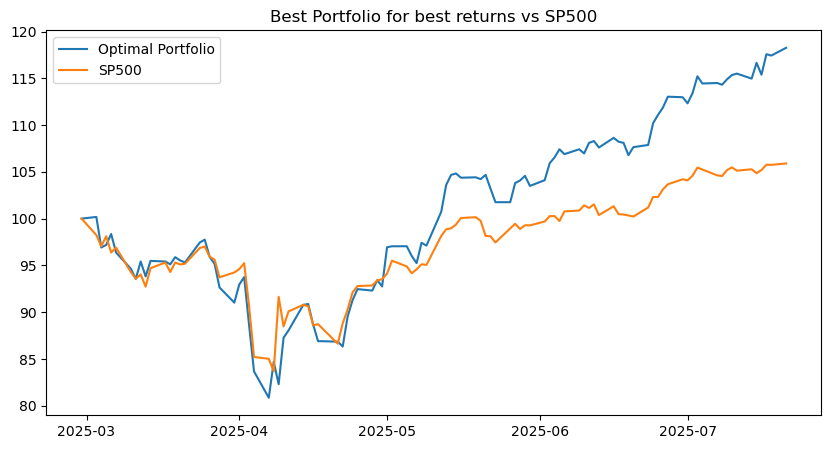

26.325788497924805 s


In [ ]:
time_start = time.time()
sims = sim_portfolio_weights(10000)
best = max(sims, key=lambda x: x['return'])

print("Optimal Weights (Max Return):")
for name, weight in zip(combined_df.columns, best['weights']):
    print(f"{name}: {weight:.4f}")

print(f"\nSharpe Ratio: {best['sharpe']:.4f}")
print(f"Annualized Volatility: {best['volatility']:.4f}")
print(f"Total Return: {best['return']:.2%}")

plt.figure(figsize=(10, 5))
plt.plot(best['cumprod'], label='Optimal Portfolio')
plt.plot(benchmark_cumprod_rebased, label='SP500')
plt.title('Best Return based Portfolio vs SP500')
plt.legend()
plt.show()

time_end = time.time()
print(time_end-time_start, 's')